In [1]:
"""
필요한 라이브러리 불러오기
"""

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from torchvision import datasets, transforms

device = torch.device("cpu")  # 학습에 사용할 장치 (GPU 또는 CPU)

In [2]:
"""
MNIST 데이터셋 불러오기
"""

dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

batch_size = 1024  # 한 번에 학습할 데이터 개수

dataloaders = torch.utils.data.DataLoader(
    dataset,
    batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

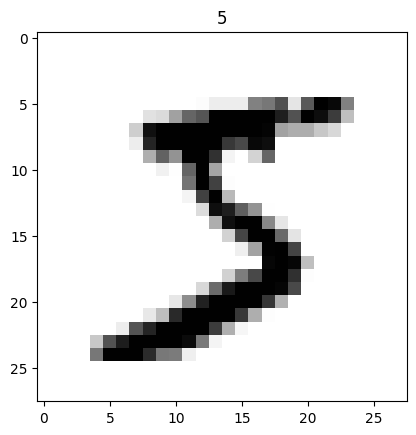

In [3]:
"""
MNIST 데이터셋 시각화
"""

import matplotlib.pyplot as plt


def plot_mnist(img, lbl):
    plt.imshow(img[0], cmap="binary")
    plt.title(lbl)
    plt.show()


image, label = dataset[0]
plot_mnist(image, label)

In [4]:
"""
AutoEncoder 모델 구현
"""

space_size = 10  # Latent space 차원


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, space_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.mlp(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)


class AutoEncoder(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.encoder = enc
        self.decoder = dec

        # He initialization
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_uniform_(param, nonlinearity="relu")
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded